In [1]:
import numpy as np
import scipy.stats as sci
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import linregress
import pickle
import os
import time

In [21]:
def graphDisks(disks,sigma,L, phi, delta, t=0, save=False):
    fig, ax=plt.subplots(figsize=(5,5))

    err=1e-10
    for _,h in enumerate(disks):
        facecolor="red" if _==0 else "lightgray"
        c=plt.Circle((h[0],h[1]),sigma,facecolor=facecolor, edgecolor="black")
        ax.add_patch(c)
        edgecolor="black"
        
        if h[0]<(sigma+err):
            _c=plt.Circle((h[0]+L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[0]>L-(sigma+err):
            _c=plt.Circle((h[0]-L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]<(sigma+err):
            _c=plt.Circle((h[0]+L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]>L-(sigma+err):
            _c=plt.Circle((h[0]-L,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)

        ax.set_xlim(0,L)
        ax.set_ylim(0,L)
    ax.set_aspect("equal")
    t = np.round(t, -1) if t!=0 else t
    ax.set_title(f"phi:{phi} d:{delta} t:{t} n:{len(disks)}")
    plt.show()
    if save==True:
        fig.savefig(f"phi-{phi}-d{delta}-t{t}-n{len(disks)}.png")

def generate_grid(phi, delta,random=False):
    s = 32
    n_disks=1024
    sigma=1
    d0 = 2*sigma
    L = np.sqrt((np.pi * n_disks * sigma**2) / (phi))
    y_sep = d0 * np.sqrt(3)/2
    if random==False:
        cols = np.arange(sigma, s*d0, d0)  # x positions
        rows = np.arange(sigma, s*y_sep, y_sep) # y positions
    else:
        # random = True --> fill entire LxL space, select random.
        cols = np.arange(sigma, L-d0, d0)  # x positions
        rows = np.arange(sigma, L-y_sep, y_sep) # y positions

    disks = []

    for i, y in enumerate(rows):
        # stagger hex. grid
        if i % 2 == 0:
            x_positions = cols
        else:
            x_positions = cols + d0/2
        for x in x_positions:
            disks.append((x+sigma, y+sigma))
    disks = np.array(disks)
    if random==True:
        disks = disks[np.random.choice(len(disks), n_disks, replace=False)]
    else:
        disks = disks[:n_disks]

    graphDisks(disks,sigma,L, phi, delta, t=0, save=True)

    Lx = np.ptp(disks[:,0])
    Ly = np.ptp(disks[:,1])
    _phi = (np.pi * n_disks * sigma**2) / (L*L)

    print(f"phi,L=({_phi:.3f}, {L:.3f})")
    return disks, L

def diskDensity(n_slabs,disks,L):
    slab_width = L/n_slabs
    disk_density=[]
    slab_indices_x = np.floor(disks[:,0] / slab_width).astype(int)
    slab_indices_y = np.floor(disks[:,1] / slab_width).astype(int)
    
    counts_x = np.bincount(slab_indices_x, minlength=n_slabs)   
    counts_y = np.bincount(slab_indices_y, minlength=n_slabs)
    density_x = counts_x / slab_width
    density_y = counts_y / slab_width
    
    centers = (np.arange(n_slabs) + 0.5) * slab_width
    return centers, density_x, density_y

def monteCarloStep(n_disks, disks, disks_unwrapped, sigma, delta, L, periodic_boundary, moves, g=0.0, m=1.0, T=1.0):
    for n in range(n_disks):
        # Select random disk + random jump
        rand_disk = np.random.randint(len(disks))
        prev_pos = disks_unwrapped[rand_disk].copy()
        d = sigma * delta
        # Random displacement
        dx = np.random.uniform() - 0.5
        dy = np.random.uniform() - 0.5
        new_pos = prev_pos + np.array([d*dx, d*dy])
        new_pos=np.asarray(new_pos)
        err=1e-12
        new_pos_unwrapped = disks_unwrapped[rand_disk] + np.array([d*dx, d*dy])
        new_pos_unwrapped=np.asarray(new_pos_unwrapped)
        if periodic_boundary==True:
            diff = disks-(new_pos_unwrapped % L)
            diff -= L * np.round(diff / L)
        else:
            # hard boundary conditions
            if new_pos[0] < sigma-err or new_pos[0] > L-(sigma+err)\
                or new_pos[1] < sigma-err or new_pos[1] > L-(sigma+err):
                continue
            else:
                diff = disks - new_pos
        diff_sq = np.sum(diff**2, axis=1)
        diff_sq[rand_disk] = np.inf  # ignore self

        if np.any(diff_sq < (2 * sigma)**2):
            continue

        if g!=0.0 and periodic_boundary==False:
        # if force acting, calculate prob
            #T=1.0
            beta=1.0/T
            dE = m*g*(new_pos[1]-prev_pos[1])
            a=min([1.0, np.exp(-beta*dE)])
            if np.random.rand() < a:
                continue
            else:
                moves+=1
                disks_unwrapped[rand_disk] = new_pos_unwrapped
                disks[rand_disk] = new_pos_unwrapped % L
        else:
            moves+=1
            disks_unwrapped[rand_disk] = new_pos_unwrapped
            disks[rand_disk] = new_pos_unwrapped % L
    
    return disks, disks_unwrapped, moves

def monteCarloSimulation(n_steps, n_disks, disks, sigma, phi, delta, L, periodic_boundary, graphs=9):
    init=disks.copy()
    disks_unwrapped=disks.copy()
    disk_tracker=[]
    msd_step=[]
    cntrs=[]
    rho_x=[]
    rho_y=[]
    n_slabs=25
    t0 = time.time()
    for step in range(n_steps):
        moves=0
        disks, disks_unwrapped, moves = monteCarloStep(n_disks, disks, disks_unwrapped, sigma, delta, L, periodic_boundary, moves)
        
        displacements = disks_unwrapped - init  # vector displacement
        msd_step.append(np.sum(displacements**2, axis=1)) # msd per disk per t step
        if (step+1)%(int(n_steps/20))==0 and step!=0:
            t1 = time.time()
            iter_time = t1 - t0
            print(f"Time taken: {iter_time:.3f}s for {step+1} MC")
            t0 = time.time()
        if (step+1)%(int(n_steps/graphs))==0 and step!=0:
            _cntrs, _rho_x, _rho_y = diskDensity(n_slabs, disks, L)
            cntrs.append(_cntrs)
            rho_x.append(_rho_x)
            rho_y.append(_rho_y)
            msd = np.mean(np.sum(displacements**2, axis=1))
            print(f"t={step+1} - {100*(moves/n_disks):.2f}% (MSD={msd:.5f}) - Time taken: {iter_time:.3f}s")
            graphDisks(disks, sigma, L, phi, delta, step, save=False)
            
        disk_tracker.append(disks.copy())

    return disks, disk_tracker, rho_x, rho_y, cntrs, msd_step


In [12]:
def graphDisksUneven(disks,sigma, Lx, Ly, phi, delta, g, t=0, save=True):
    fig, ax=plt.subplots(figsize=(2,10))

    err=1e-10
    for _,h in enumerate(disks):
        facecolor="red" if _==0 else "lightgray"
        c=plt.Circle((h[0],h[1]),sigma,facecolor=facecolor, edgecolor="black")
        ax.add_patch(c)
        edgecolor="black"
        
        if h[0]<(sigma+err):
            _c=plt.Circle((h[0]+Lx,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[0]>Lx-(sigma+err):
            _c=plt.Circle((h[0]-Lx,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]<(sigma+err):
            _c=plt.Circle((h[0]+Ly,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)
        if h[1]>Ly-(sigma+err):
            _c=plt.Circle((h[0]-Ly,h[1]),sigma,facecolor="gray", edgecolor=edgecolor)
            ax.add_patch(_c)

        ax.set_xlim(0,Lx)
        ax.set_ylim(0,Ly)
    #ax.set_aspect("")
    t = np.round(t, -1) if t!=0 else t
    ax.set_title(f"phi:{phi} d:{delta} g:{g} t:{t} n:{len(disks)}")
    #plt.tight_layout()
    plt.show()
    if save==True:
        fig.savefig(f"g{g}-phi-{phi}-d{delta}-t{t}-n{len(disks)}.png")

def generateGridUneven(phi, delta, g, random=True):
    s = 50
    n_disks=1024
    sigma=1
    d0 = 2*sigma
    L = np.sqrt((np.pi * n_disks * sigma**2) / (phi))
    Lx=s
    Ly=10*s
    y_sep = d0 * np.sqrt(3)/2
    cols = np.arange(sigma, Lx-d0, d0)  # x positions
    rows = np.arange(sigma, Ly-y_sep, y_sep) # y positions

    disks = []

    for i, y in enumerate(rows):
        # stagger hex. grid
        if i % 2 == 0:
            x_positions = cols
        else:
            x_positions = cols + d0/2
        for x in x_positions:
            disks.append((x+sigma, y+sigma))
    disks = np.array(disks)
    if random==True:
        disks = disks[np.random.choice(len(disks), int(n_disks), replace=False)]
    else:
        disks = disks[:n_disks]

    graphDisksUneven(disks, sigma, Lx, Ly, phi, delta,g, t=0,  save=True)
    _phi = (np.pi * n_disks * sigma**2) / (Lx*Ly)

    print(f"phi,L=({_phi:.3f}, {Lx:.3f} {Ly:.3f})")
    return disks, Lx, Ly

def monteCarloStepUneven(n_disks, disks, sigma, delta, Lx,Ly, moves, g, T=1.0,m=1.0):
    for n in range(n_disks):
        # Select random disk + random jump
        rand_disk = np.random.randint(len(disks))
        prev_pos = disks[rand_disk].copy()
        d = sigma * delta
        # Random displacement
        dx = np.random.uniform() - 0.5
        dy = np.random.uniform() - 0.5
        new_pos = prev_pos + np.array([d*dx, d*dy])
        new_pos=np.asarray(new_pos)
        err=1e-12

        if new_pos[0] < sigma-err or new_pos[0] > Lx-(sigma+err)\
            or new_pos[1] < sigma-err or new_pos[1] > Ly-(sigma+err):
            continue
        else:
            diff = disks - new_pos
        diff_sq = np.sum(diff**2, axis=1)
        diff_sq[rand_disk] = np.inf  # ignore self

        if np.any(diff_sq < (2 * sigma)**2):
            continue

        beta=1.0/T
        dE = m*g*(new_pos[1]-prev_pos[1])
        a=min([1.0, np.exp(-beta*dE)])
        if np.random.rand() < a:
            moves+=1
            disks[rand_disk] = new_pos
    
    return disks, moves

def monteCarloSimulationUneven(n_steps, n_disks, disks,disk_tracker, sigma, phi, delta, Lx, Ly, g, T,graphs=4):
    init=disks.copy()
    disk_tracker=[]
    msd_step=[]
    tot_time=0.0
    t0 = time.time()
    for step in range(n_steps):
        moves=0
        disks, moves = monteCarloStepUneven(n_disks, disks, sigma, delta, Lx, Ly, moves, g=g, T=T)
        displacements = disks - init  # vector displacement
        msd_step.append(np.sum(displacements**2, axis=1)) # msd per disk per t step
        if (step+1)%(int(n_steps/100))==0 and step!=0:
            t1 = time.time()
            iter_time = t1 - t0
            tot_time += iter_time
            msd = np.mean(np.sum(displacements**2, axis=1))
            print(f"t={step+1} - {100*(moves/n_disks):.2f}% (MSD={msd:.5f})   |    t: {iter_time:.3f}s - total: {int(tot_time)//60}m:{int(tot_time)%60}s")
            t0 = time.time()
        if (step+1)%(int(n_steps/graphs))==0 and step!=0:
            msd = np.mean(np.sum(displacements**2, axis=1))
            print(f"t={step+1} - {100*(moves/n_disks):.2f}% (MSD={msd:.5f}) - t: {iter_time:.3f}s - total: {int(tot_time)//60}m:{int(tot_time)%60}s")
            graphDisksUneven(disks, sigma, Lx+1, Ly, phi, delta,g, step, save=True)
            
        disk_tracker.append(disks.copy())
    print(f"Time elapsed: {tot_time}")
    return disks, disk_tracker, msd_step


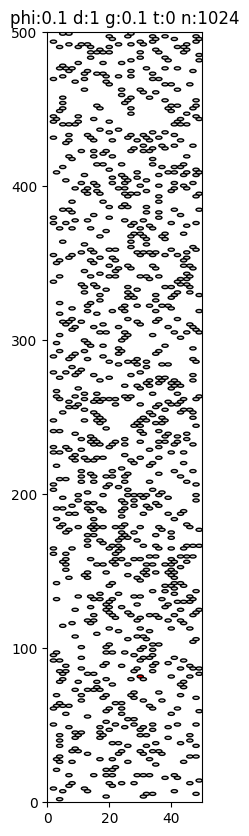

phi,L=(0.129, 50.000 500.000)
Run 0[50000]: g=0.1 T=1.0 Lx=50.00 Ly=500.00


KeyboardInterrupt: 

In [13]:
n_steps=50000
n_disks=1024
periodic_boundary=True
g=0.1
gs=[1] 
T=1.0
Ts= [1.0]
phi=0.1
sigma=1
deltas=[1]
msd_total=[]
disk_tracker=[]

# number of graphs you wanna see per run
graphs=8

start_time = time.time()
random=True
for run,_delta in enumerate(deltas):
    #disks,L=generate_grid(phi, _delta, random)
    for T in Ts:
        disk_tracker=[]
        #n_steps = n_steps if g!=10 or g!=1 else 25000
        disks,Lx,Ly=generateGridUneven(phi, _delta, g)

        print(f"Run {run}[{n_steps}]: g={g} T={T} Lx={Lx:.2f} Ly={Ly:.2f}")
        t0 = time.time()
        disks,disk_tracker, msd_step = monteCarloSimulationUneven(n_steps, n_disks, disks,disk_tracker, sigma, phi, _delta, Lx,Ly,g,T,graphs=graphs)
        msd_total.append(msd_step)
        
        t1 = time.time()
        iter_time = t1 - t0
        print(f"Time taken: {iter_time:.3f}s")

        # Dump positions into pickle file
        #filename = os.path.join(os.getcwd(), f"g{g}--T{T}-POS_d{_delta}-phi{phi}-t{n_steps+150000}-random{str(random)}.pkl")
        #with open(filename, 'wb') as f:
        #    pickle.dump(disk_tracker, f)

        # Save Final Pos
        graphDisksUneven(disks, sigma, Lx,Ly, phi, _delta, g, n_steps, save=False)

    #filename2 = os.path.join(os.getcwd(), f"g{g}-LONG-MSD_phi{phi}-d{_delta}-t{n_steps+150000}-random{str(random)}.pkl")
    #with open(filename2, 'wb') as f:
    #    pickle.dump(msd_total, f)


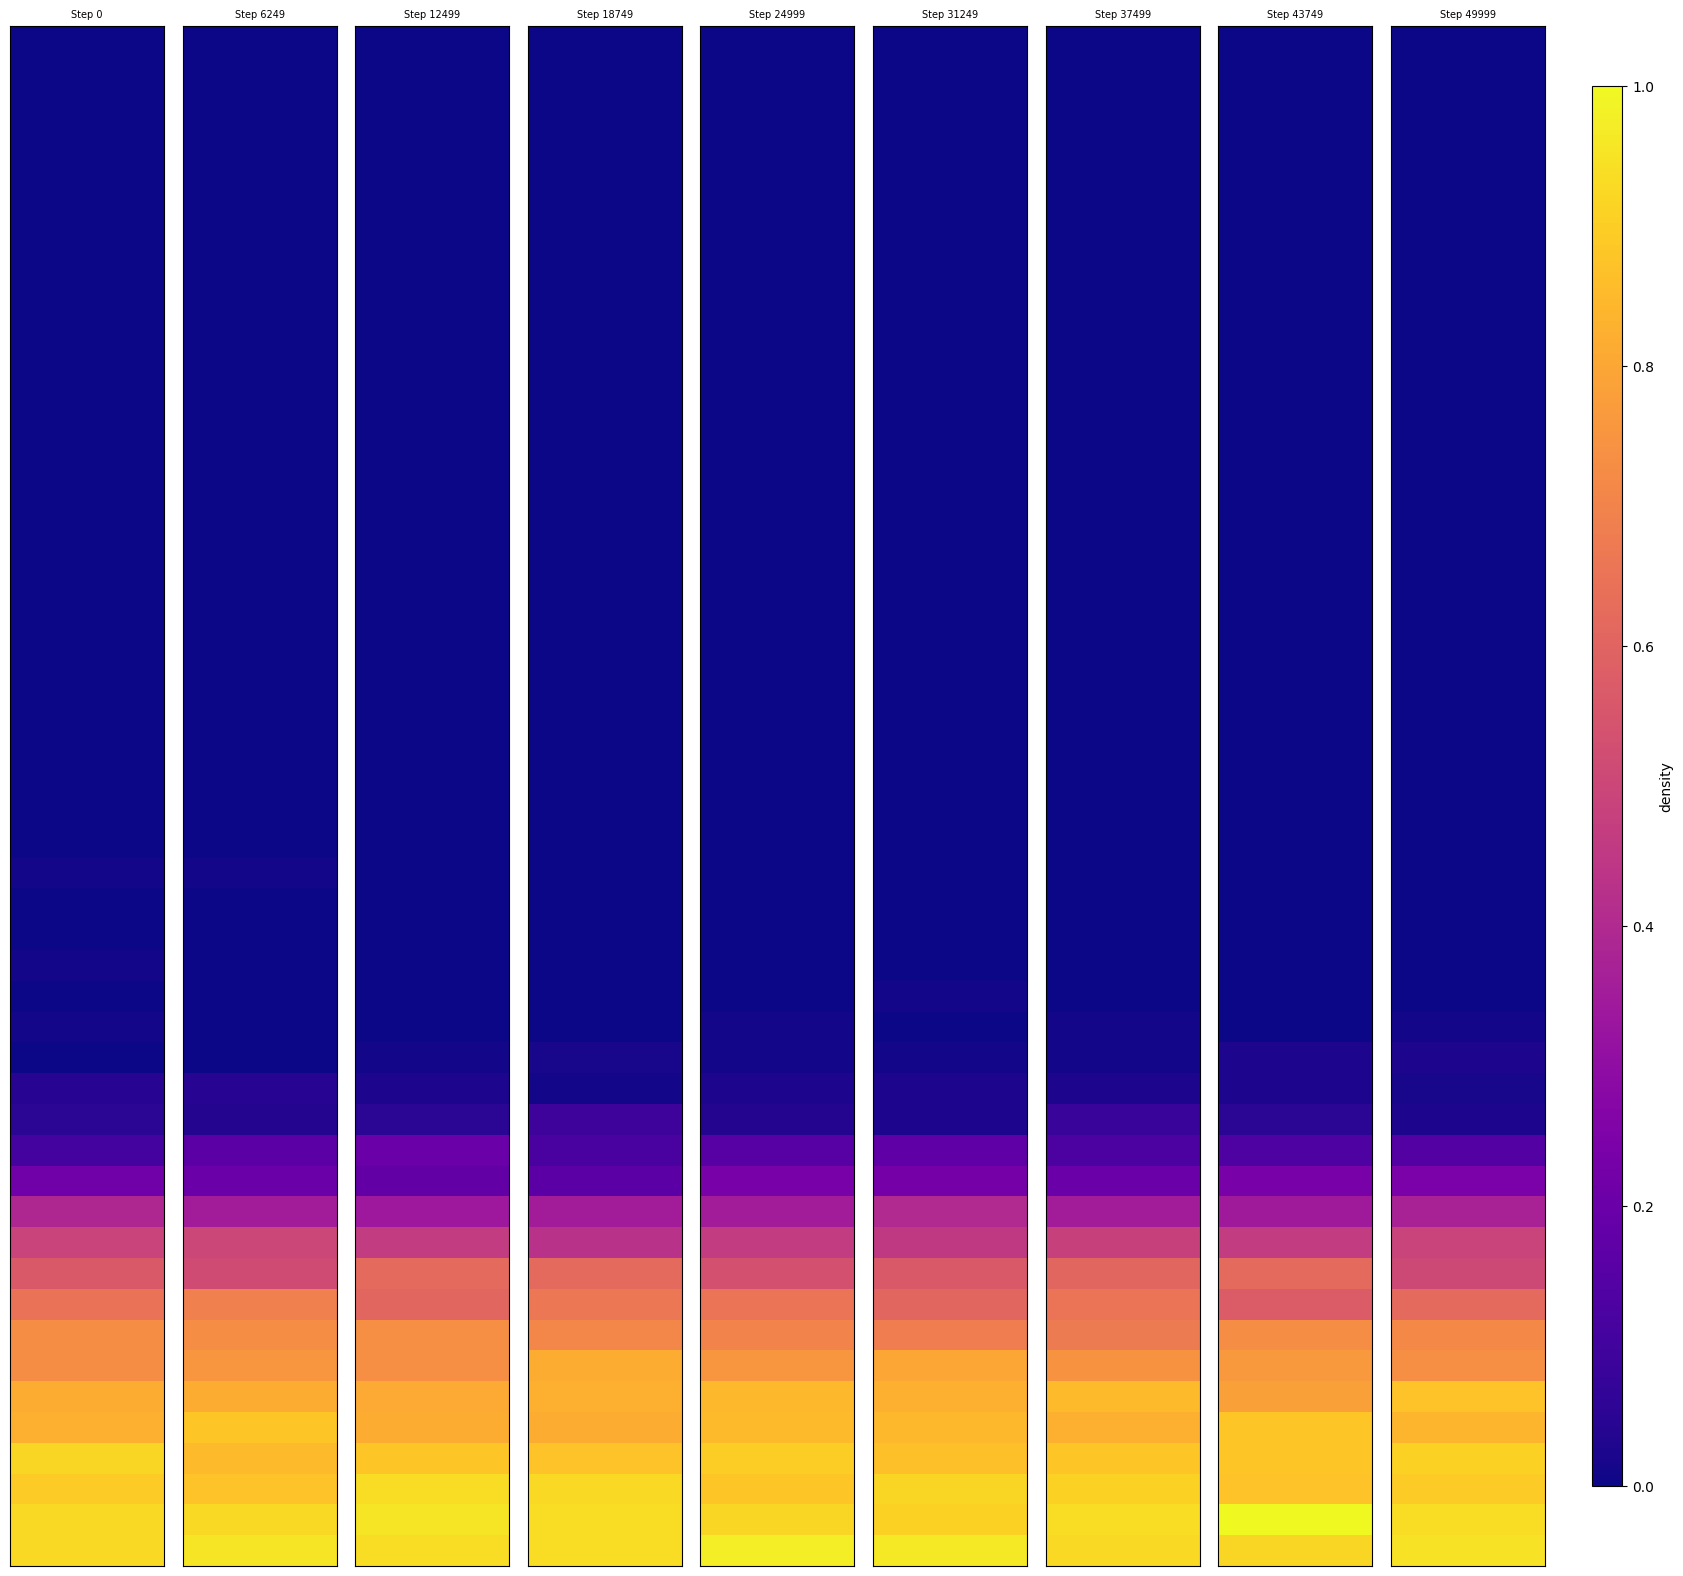

In [62]:
def plot9DensitySnapshots_rect(disk_tracker, Lx, Ly, loc, n_slabs_x=1, n_slabs_y=15, cmap='plasma'):
    n_steps = disk_tracker.shape[0]
    step_indices = np.linspace(0, n_steps-1, 9, dtype=int)

    fig, axes = plt.subplots(1, 9,figsize=(20,20),      gridspec_kw=dict(wspace=0.02))   
    axes = axes.flatten()

    histograms = []
    for step in step_indices:
        frame = disk_tracker[step]
        x = frame[:, 0]
        y = frame[:, 1]
        # 2D histogram for rectangular box
        H, _, _ = np.histogram2d(x, y,bins=[n_slabs_x, n_slabs_y],range=[[0, Lx], [0, Ly]])
        histograms.append(H)

    vmin = min(H.min() for H in histograms)
    vmax = max(H.max() for H in histograms)

    # Plot each histogram
    ims = []
    for ax, H, step in zip(axes, histograms, step_indices):
        Hn = (H - vmin) / (vmax - vmin)
        im = ax.imshow(
            Hn.T,
            origin='lower',
            extent=[0, Lx, 0, Ly],
            cmap=cmap,
            aspect='equal',
            vmin=0,
            vmax=1
        )
        ax.set_title(f"Step {step}", fontsize=7)
        ax.set_xticks([]); ax.set_yticks([])
        ims.append(im)

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(ims[0], cax=cbar_ax, label='density')
    plt.show()
    fig.savefig(loc)

gs=[0.01,0.1,1,10]
for T in Ts:
    # Choose pickle and output file name
    filename = os.getcwd() + f"/g0.1--T{T}-POS_d1-phi0.1-t200000-randomTrue.pkl"
    fname=f"g0.1-T{T}-DENSITY_d1-phi0.1-t200000-randomTrue.png"

    with open(filename, 'rb') as f:
        disk_tracker = pickle.load(f)

    disk_tracker = np.asarray(disk_tracker)

    plot9DensitySnapshots_rect(disk_tracker, Lx, Ly,loc=fname,
                            n_slabs_x=1, n_slabs_y=50)

In [14]:
def load_and_combine(pkl_list):
    all_segments = []
    for fpath in pkl_list:
        with open(fpath, "rb") as f:
            segment = pickle.load(f)
        all_segments.append(np.asarray(segment))

    # concatenate along time axis
    #combined = np.concatenate(all_segments, axis=0)
    #return combined
    return all_segments

files = [
    os.getcwd() + f"/g0.1--T0.1-POS_d1-phi0.1-t25000-randomTrue.pkl",
    os.getcwd() + f"/g0.1--T1.0-POS_d1-phi0.1-t25000-randomTrue.pkl",
    os.getcwd() + f"/g0.1--T10-POS_d1-phi0.1-t25000-randomTrue.pkl",
]

all_disk_tracker = load_and_combine(files)
all_disk_tracker=np.array(all_disk_tracker)
print(all_disk_tracker.shape)

(3, 25000, 1024, 2)


In [15]:
try:
    def density_profile_over_time(disk_tracker, Lx, Ly, n_slabs):
        n_steps = disk_tracker.shape[0]
        slab_height = Ly / n_slabs

        centers_y = (np.arange(n_slabs) + 0.5) * slab_height
        rho_t = np.zeros((n_steps, n_slabs))

        slab_area = Lx * slab_height

        for t in range(n_steps):
            y = disk_tracker[t][:, 1]

            # compute which slab each particle is in
            slab_indices = np.floor(y / slab_height).astype(int)
            slab_indices = np.clip(slab_indices, 0, n_slabs - 1)

            # count particles in slabs
            counts = np.bincount(slab_indices, minlength=n_slabs)

            # convert to number density
            rho_t[t] = counts / slab_area
        rho_t = (rho_t - np.min(rho_t)) / (np.max(rho_t) - np.min(rho_t))
        return centers_y, rho_t
    def plot_density_relaxation(centers_y, rho_t, n_plots=10):

        n_steps = rho_t.shape[0]
        time_indices = np.linspace(0, n_steps - 1, n_plots, dtype=int)

        plt.figure(figsize=(6, 8))

        for idx in time_indices:
            plt.plot(rho_t[idx], centers_y, label=f"t={idx}")

        plt.xlabel("Density ρ(y)")
        plt.ylabel("Height y")
        plt.title("Relaxation of Density Profile")
        plt.legend()
        plt.gca().invert_yaxis()  # optional (0 at bottom)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    centers_y, rho_t = density_profile_over_time(
        disk_tracker,
        Lx, Ly,
        n_slabs=50
    )
    plot_density_relaxation(centers_y, rho_t, n_plots=10)
except:
    NameError



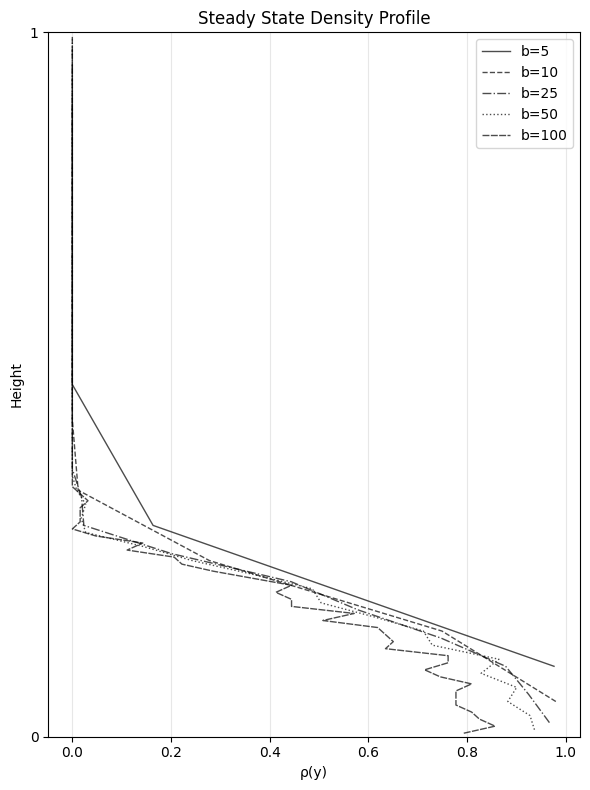

In [97]:
linestyles = ["-", "--", "-.", ":", (0,(5,1))]
bins_list  = [5, 10, 25, 50, 100]

plt.figure(figsize=(6, 8))

for b, ls in zip(bins_list, linestyles):

    centers_y, rho_t = density_profile_over_time(
        disk_tracker, Lx, Ly, n_slabs=b
    )

    final_idx = rho_t.shape[0] - 1   # last time step

    plt.plot(
        rho_t[final_idx], centers_y,
        linestyle=ls, color="black", linewidth=1,
        label=f"b={b}",
        alpha=0.7
    )

plt.xlabel("ρ(y)")
plt.ylabel("Height")
plt.title("Steady State Density Profile")
plt.ylim(0, centers_y[-1])   # full height visible
plt.yticks(ticks=[0, Ly],labels=[0,1])
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [111]:
disk_tracker.shape

(1024, 2)

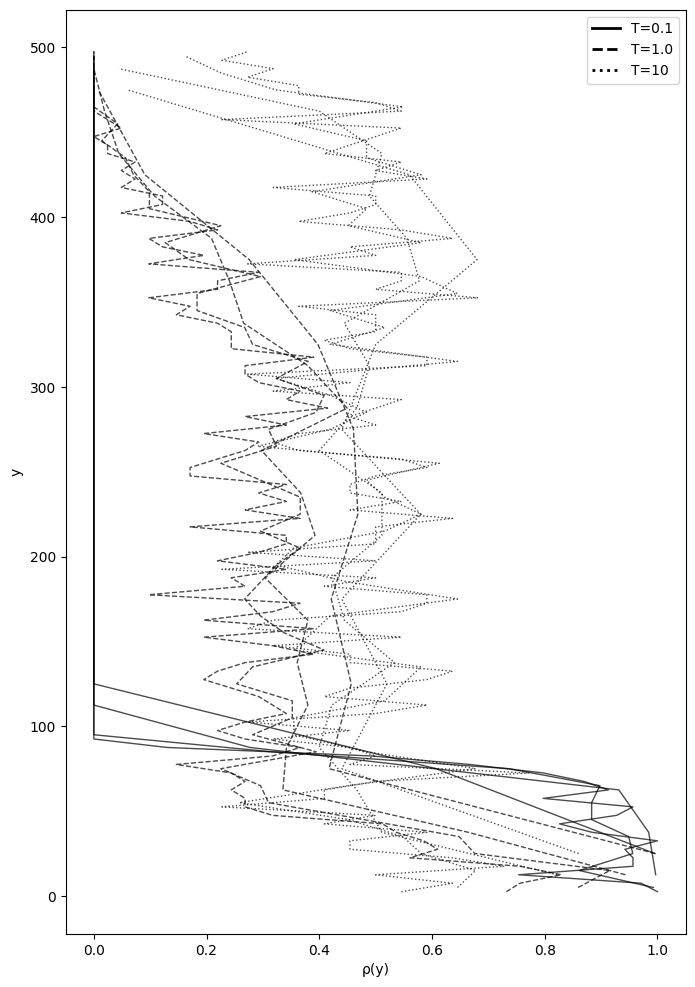

In [24]:
linestyles = ['-', '--', ':']  # one per disk_tracker list
bins_list = [10, 20, 50, 100]  # your binnings
temps = [0.1, 1.0, 10]          # for labeling

plt.figure(figsize=(8,12))

for sim_idx in range(3):
    traj = all_disk_tracker[sim_idx]  # shape (25000, 1024, 2)
    
    for b in bins_list:
        centers_y, rho_t = density_profile_over_time(traj, Lx, Ly, n_slabs=b)
        final_idx = rho_t.shape[0] - 1
        plt.plot(
            rho_t[final_idx], centers_y,
            linestyle=linestyles[sim_idx],
            color="black",
            linewidth=1,
            alpha=0.7,
            # no label here to avoid repeating
        )

# Make legend manually with only 3 lines for the 3 linestyles
legend_lines = [plt.Line2D([0], [0], color='black', linestyle=ls, linewidth=2)
                for ls in linestyles]
legend_labels = [f"T={t}" for t in temps]
plt.legend(legend_lines, legend_labels)

plt.xlabel("ρ(y)")
plt.ylabel("y")
plt.show()

In [106]:
# black & white line styles, one for each b
linestyles = ["-", (0,(5,1)), "--", "-.", ":"]

bins_list = [5, 10, 25, 50, 100]

plt.figure(figsize=(6, 8))

for b, ls in zip(bins_list, linestyles):

    # compute density using YOUR function
    centers_y, rho_t = density_profile_over_time(
        disk_tracker, Lx, Ly, n_slabs=b
    )

    # choose 4 time points
    n_steps = rho_t.shape[0]
    time_indices = np.linspace(0, n_steps - 1, 4, dtype=int)

    # plot 4 curves for this bin count
    for t_idx in time_indices:
        plt.plot(
            rho_t[t_idx], centers_y,
            linestyle=ls, color="black", linewidth=1, alpha=0.6,
        )

legend_lines = [plt.Line2D([0], [0], color='black', linestyle=ls, linewidth=2)
                for ls in linestyles]
legend_labels = [f"b={b}" for b in bins_list]

plt.legend(handles=legend_lines, labels=legend_labels, loc='best', frameon=False)
plt.xlabel("ρ(y)")
plt.ylabel("Height")
plt.title("Steady State Density Profile")
plt.ylim(0, centers_y[-1])   # full height visible
plt.yticks(ticks=[0, Ly],labels=[0,1])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 600x800 with 0 Axes>

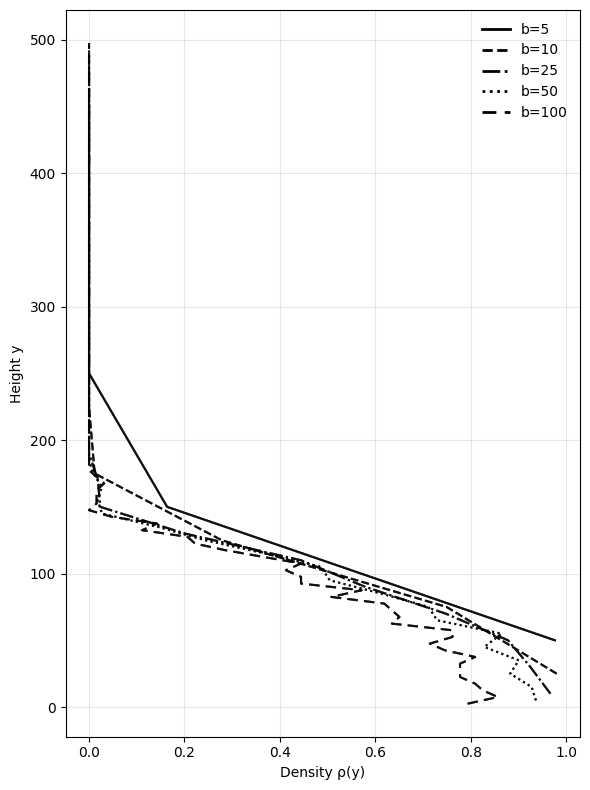

In [98]:
linestyles = ["-", "--", "-.", ":", (0,(5,3))]
bins_list  = [5, 10, 25, 50, 100]
temps = [0.1, 1.0, 10.0]  # example temperatures

plt.figure(figsize=(6,8))

for T in temps:
    # load disk_tracker for this temperature (replace with your actual loading)
    # e.g., disk_tracker = load_pickle_for_T(T)
    
    for b, ls in zip(bins_list, linestyles):
        centers_y, rho_t = density_profile_over_time(disk_tracker, Lx, Ly, n_slabs=b)
        final_idx = rho_t.shape[0] - 1

        # plot final-time density for this T
        plt.plot(
            rho_t[final_idx], centers_y,
            linestyle=ls, color="black", linewidth=1.5, alpha=0.6
        )

plt.xlabel("Density ρ(y)")
plt.ylabel("Height y")
plt.grid(True, alpha=0.3)

# Custom legend: only one entry per bin
from matplotlib.lines import Line2D

legend_lines = [Line2D([0], [0], color='black', linestyle=ls, linewidth=2)
                for ls in linestyles]
legend_labels = [f"b={b}" for b in bins_list]

plt.legend(handles=legend_lines, labels=legend_labels, loc='best', frameon=False)

plt.tight_layout()
plt.show()


In [103]:
linestyles = ["-", "--", "-.", ":", (0,(5,3))]
bins_list  = [5, 10, 25, 50, 100]
temps = [0.1, 1.0, 10.0] 


plt.figure(figsize=(6,8))

# iterate over tracker and its corresponding temperature
for disk_tracker, T in zip(all_disk_tracker, temps):
    for b, ls in zip(bins_list, linestyles):
        centers_y, rho_t = density_profile_over_time(disk_tracker, Lx, Ly, n_slabs=b)
        final_idx = rho_t.shape[0] - 1

        plt.plot(
            rho_t[final_idx], centers_y,
            linestyle=ls, color="black", linewidth=1.5, alpha=0.6,
            label=f"T={T}, b={b}"  # only for illustration if needed
        )

plt.xlabel("Density ρ(y)")
plt.ylabel("Height y")
plt.grid(True, alpha=0.3)

# Custom legend: only one per bin (linestyle), no duplicates
from matplotlib.lines import Line2D
legend_lines = [Line2D([0], [0], color='black', linestyle=ls, linewidth=2)
                for ls in linestyles]
legend_labels = [f"b={b}" for b in bins_list]

plt.legend(handles=legend_lines, labels=legend_labels, loc='best', frameon=False)
plt.tight_layout()
plt.show()



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 600x800 with 0 Axes>